# Implementation and Application of Logistic Regression Model Using Numpy and Scipy

### by Yuan Huang

This project implemented a logistic regression model using numpy, scipy.optimization, and tested the classification performance of the model using several tools from sklearn.model_selection, including confusion_matrix, classification_report and ROC curve. In addition, GridSearchCV was used to optimize the lambda value for the regulated regression and the degree of polynomial of the model for solving non-linear separable problem in test case 3. Some data visualization was shown using pandas and matplotlib for data exploration, which provides useful inoformation for modeling. In addition, ROC curve and the decision boundary were plotted using matplotlib for model evaluation.

### Load the libraries and simulated datasets for testing

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap 
from scipy import optimize 
from scipy.special import expit
%matplotlib inline

Exams and product are two simulated datasets including two predictors each. In exams dataset, we try to predict whether or not a student will get admission (0 or 1) to a program based on the scores of two tests he/she took. In the product dataset, we predict if the quality of a product can pass the evaluation (0 or 1) based on the scores of two test measurements. 

First, we load the data

In [39]:
exams=pd.read_csv('ex2data1.txt',header=None)
exams.columns=['exam1','exam2','admission']
product=pd.read_csv('ex2data2.txt',header=None)
product.columns=['test1','test2','quality']

Then we explore the data to see if there is any correlation between feature variables, and whether the data points are linear separable on two dimensional space.

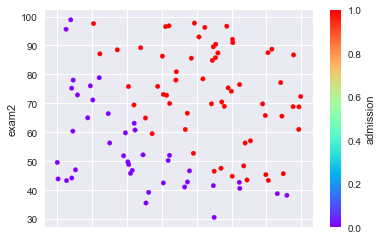

In [40]:
exams.plot.scatter(x='exam1',y='exam2',c='admission',cmap='rainbow')


It seems that for "exams" dataset, the two exam scores are independently distributed, and the data points are close to be "linear separable" in terms of the admission. 

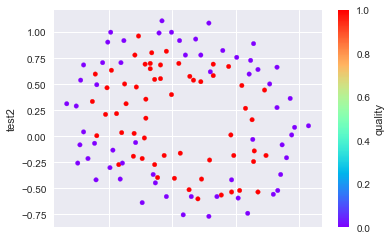

In [41]:
product.plot.scatter('test1','test2',c='quality',cmap='rainbow')

For "product" dataset, the two test scores are independently distributed, and the data points are not "linear separable" in two dimensional space. 

### Implementation of the logistic regression model
The logistic regression model implementation includes the functionalities of normalizing the data by column mean and standard deviation. It fits regression coefficients using gradient descendent. Gradient descendent optimization was accomplished by BFGS algorithm implemented in scipy.optimization package.

In [42]:
from sklearn.base import BaseEstimator, ClassifierMixin
class LogisticReg(BaseEstimator, ClassifierMixin):
    def __init__(self,lmd=0,normalize=True):
        '''
        input:
           normalized: if the data need to be normalized
           mode: using gradient descent or normal equation to find theta
        '''
        self.normalize=normalize
        self.lmd=lmd       
       
        
    def _normalize(self,X):
        '''
        input:
          X: feature matrix for training dataset
          
        output:
          returns the normalized training dataset, and set up the column means and std for
          normalizing test dataset
        '''
        self.feature_center=X.mean(axis=0)
        self.feature_std=X.std(axis=0)
        return (X-self.feature_center)/self.feature_std
        
    def _costCompute(self,theta,X,y):
        '''
        input: 
           X: n times m matrix, n is the number of observations, and m is the number of features, including intecept
           y: n times 1 vector
           theta: m times 1 vector, corresponding to the regression coefficients, including intercept
           lmd: scalar variable, corresponding to the penalty of the large regression coefficients 
       
        output:
           a scalar variable corresponding to the cost
        '''  
        num_obs=float(len(y))
        lld=y.dot(np.log(expit(X.dot(theta))))+(1-y).dot(np.log(1-expit(X.dot(theta))))
        
        return -1.0/num_obs*lld+0.5*self.lmd/num_obs*theta[1:].dot(theta[1:])

    def _gradCompute(self,theta,X,y):
        '''
        input:
           X: n times m matrix, n is the number of observations, and m is the number of features, including intercept
           y: n times 1 vector
           theta: m times 1 vector, corresponding to the regression coefficients of m features, including intercept
           
        output:
           returns the gradient of the theta parameter
        '''
        num_obs=float(len(y))
        regular_grad=-1.0/num_obs*X.T.dot(y-expit(X.dot(theta)))
        #grad=regular_grad[1:]+lmd*theta[1:]
        regular_grad[1:]+=self.lmd/num_obs*theta[1:]
        return regular_grad 
    
    def fit(self,X,y):
        '''
        input:
           X: n times m matrix, n is the number of observations, and m is the number of features, including intercept
           y: n times 1 target variable vector
           
        output:
          fit the data by linear regression using gradient desendent, and set the _theta values
        '''
        num_obs=X.shape[0]
        num_features=X.shape[1]
        
        #normalize the training dataset
        if self.normalize:
            X=self._normalize(X)
            
        # insert intercept column
        X=np.hstack((np.ones((num_obs,1)),X))
        
        #set the initial values for theta
        theta=np.zeros(num_features+1)
        self.theta=theta        
        #find the optimum theta values that minimize cost function
        rs=optimize.minimize(fun=self._costCompute, x0=theta, args=(X,y),method='BFGS',jac=self._gradCompute)
        #print(rs.message)
        if rs.success:
            self.theta=rs.x
        return self
            
    def predict_proba(self,X_new):
        '''
        input: 
          X_new a n time m feature matrix for a new dataset to be predicted by model
          
        output:
          predicted target variable vector (n time 1)
        '''
        num_obs=X_new.shape[0]
        
        if self.normalize:
            X_new=(X_new - self.feature_center)/self.feature_std
                           
        return expit(np.hstack((np.ones((num_obs,1)),X_new)).dot(self.theta))
    
    def predict(self,X_new):
        return np.where(self.predict_proba(X_new)>=0.5,1,0)
    

### Testing the logistic regression model

#### Test case 1: exams dataset
First, we load the exams dataset, and define the feature matrix, X and the target variable vector, y.

In [43]:
X_exam=exams[['exam1','exam2']].values
y_exam=exams['admission'].values

To evaluate the model, we first split the dataset to training and test datasets, fit the logistic regression model using the training dataset, and then evaluate the model performance using the test dataset by confusion_matrix and classification_report implemented in sklearn.

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score,roc_curve

In [45]:
X_train_exam,X_test_exam,y_train_exam,y_test_exam=train_test_split(X_exam,y_exam,test_size=0.4,random_state=101)

lr1=LogisticReg()
lr1.fit(X_train_exam,y_train_exam)
y_pred=lr1.predict(X_test_exam)
y_prob=lr1.predict_proba(X_test_exam)

Now, we evaluate the classification results by several metrics, first, we use confusion matrix and classification report

In [46]:
print"confusion matrix\n",confusion_matrix(y_test_exam,y_pred),"\n"
print"classification report\n",classification_report(y_test_exam,y_pred)

confusion matrix
[[15  4]
 [ 0 21]] 

classification report
             precision    recall  f1-score   support

          0       1.00      0.79      0.88        19
          1       0.84      1.00      0.91        21

avg / total       0.92      0.90      0.90        40



From the confustion matrix and classification report, we can see the precision and recall are very good. Next, we will use the ROC curve and the area under the curve of ROC (ROC_AUC_Score) to evaluate the classification results.

In [47]:
fpr,tpr,_=roc_curve(y_test_exam,y_prob)

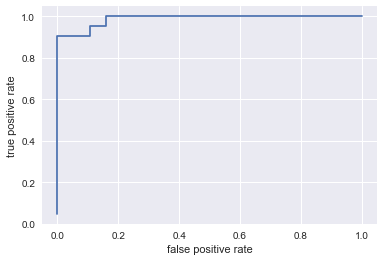

In [48]:
plt.plot(fpr,tpr)
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")

This figure shows a very good ROC curver, indicating both good specificity and sensitivity. We also evaluate the under the curve area of the ROC curve, which has a high value close to 1, as shown below: 

In [49]:
roc_auc_score(y_test_exam,y_prob)

0.98746867167919794

We can further visualize the decision boundary obtained by the model using the plotDecisionBoundary function implemented as below:

In [50]:
def plotDecisionBoundary(X,y,classifier,data_idx=None,resolution=0.02):
    #set up marker and color
    sns.reset_orig
    colors=('red','blue','lightgreen','gray','cyan')
    makers=('s','x','o','^','v')
    cmap=ListedColormap(colors[:len(np.unique(y))])
    
    #define the region of the dataset
    X1_min,X1_max,X2_min,X2_max=X[:,0].min()-0.5,X[:,0].max()+0.5,X[:,1].min()-0.5,X[:,1].max()+0.5
    
    X1,X2=np.meshgrid(np.arange(X1_min,X1_max,resolution),
                      np.arange(X2_min,X2_max,resolution))
    z=classifier.predict(np.array([X1.ravel(),X2.ravel()]).T)
    z=z.reshape(X1.shape)
    plt.figure(figsize=(8,5))
    plt.contourf(X1,X2,z,alpha=0.4,cmap=cmap)
    
    for idx, label in enumerate(np.unique(y)):
        plt.scatter(X[y==label,0],X[y==label,1],c=cmap(idx),
                    marker=makers[idx],alpha=0.8,label=label,s=5)

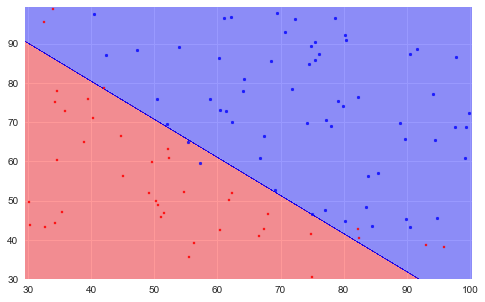

In [51]:
plotDecisionBoundary(X_exam,y_exam,classifier=lr1)

Conclusion: The classification results are pretty good. This is consistent to our observation that the patten of the data points in the "exams" dataset are very close to be "linear separable". 

#### Test case 2: product quality dataset using two features
Now we apply the logistic regression model to the product quality dataset. First, we will try the linear model that only includes the test 1 and test 2 scores in the dataset. In fact, we can easily predict that this model will not work well since the decision boundary of the data points showed that the data points of this dataset are not linear separable on the two dimensional space. Let's first split the dataset to training and test datasets, fit the training dataset, and then evaluate the test dataset results.

In [52]:
X_quality=product[['test1','test2']].values
y_quality=product['quality'].values
X_train_quality,X_test_quality,y_train_quality,y_test_quality=train_test_split(X_quality,y_quality,test_size=0.4,random_state=101)

lr2=LogisticReg()
lr2.fit(X_train_quality,y_train_quality)
y_pred=lr2.predict(X_test_quality)
y_prob=lr2.predict_proba(X_test_quality)

In [53]:
print"confusion matrix\n",confusion_matrix(y_test_quality,y_pred),"\n"
print"classification report\n",classification_report(y_test_quality,y_pred)
print"ROC_AUC_SCORE",roc_auc_score(y_test_quality,y_pred)

confusion matrix
[[ 5 21]
 [ 2 20]] 

classification report
             precision    recall  f1-score   support

          0       0.71      0.19      0.30        26
          1       0.49      0.91      0.63        22

avg / total       0.61      0.52      0.46        48

ROC_AUC_SCORE 0.550699300699


As shown by the confusion matrix and classification report, the precision and recall are not good. Furthermore, the ROC_AUC_Score is only 0.55, just slightly better then a classifier based on random guessing. We can show the decision boundary obtained using the plotDecisionBoundary funtion

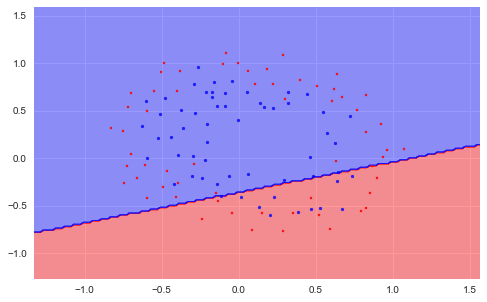

In [54]:
plotDecisionBoundary(X_quality,y_quality,classifier=lr2)

### Test case 3: product dataset using polynomial fittings
Since the decision boundary of the product dataset is not linear separable in two dimensional space, we could not get good classification results using only two features in logistic regression. One strategy we would try is to use polynomial items derived from the two existing features, and check if we can get the non-linear decision boundary to separate the data points in this dataset. To generate the polynomial feature matrix, we use the polynomialFeatures function from sklearn.preprocessing. We then train the regularized logistic regression model and optimize the lambda value and degree of the polynomial model using GridSearchCV (cv=10). Finally, we predict the test dataset using the best tuned model and evaluate the performance of the tuned model.  

In [55]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

lambda_range = [0.1,1,5,10,50]
degree_range=range(1,5,1)

pipeSVC=Pipeline([('polynom',PolynomialFeatures()),('clf',LogisticReg(normalize=False))])
gsv=GridSearchCV(estimator=pipeSVC,param_grid=[{'clf__lmd':lambda_range},{'polynom__degree':degree_range}],
                 scoring='accuracy',cv=10)
gsv.fit(X_train_quality,y_train_quality)
gsv.best_estimator_

Pipeline(memory=None,
     steps=[('polynom', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('clf', LogisticReg(lmd=0, normalize=False))])

In [56]:
y_pred=gsv.predict(X_test_quality)
y_pred_prob=gsv.predict_proba(X_test_quality)
print(classification_report(y_test_quality,y_pred))

             precision    recall  f1-score   support

          0       0.92      0.92      0.92        26
          1       0.91      0.91      0.91        22

avg / total       0.92      0.92      0.92        48



('ROC AUC score is: ', 0.96328671328671334)


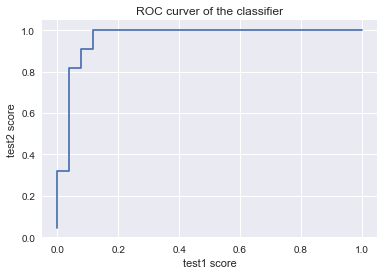

In [57]:
fpr,tpr,_=roc_curve(y_test_quality,y_pred_prob)
plt.plot(fpr,tpr)
plt.xlabel("test1 score")
plt.ylabel("test2 score")
plt.title("ROC curver of the classifier")
print("ROC AUC score is: ",roc_auc_score(y_test_quality,y_pred_prob))

In [58]:
def plotDecisionBoundary(X,y,classifier,data_idx=None,resolution=0.02):
    #set up marker and color
    sns.reset_orig
    colors=('red','blue','lightgreen','gray','cyan')
    makers=('s','x','o','^','v')
    cmap=ListedColormap(colors[:len(np.unique(y))])
    
    #define the region of the dataset
    X1_min,X1_max,X2_min,X2_max=X[:,0].min()-0.5,X[:,0].max()+0.5,X[:,1].min()-0.5,X[:,1].max()+0.5
    
    X1,X2=np.meshgrid(np.arange(X1_min,X1_max,resolution),
                      np.arange(X2_min,X2_max,resolution))
    z=classifier.predict(np.array([X1.ravel(),X2.ravel()]).T)
    z=z.reshape(X1.shape)
    plt.figure(figsize=(8,5))
    plt.contourf(X1,X2,z,alpha=0.4,cmap=cmap)
    
    for idx, label in enumerate(np.unique(y)):
        plt.scatter(X[y==label,0],X[y==label,1],c=cmap(idx),
                    marker=makers[idx],alpha=0.8,label=label,s=5)

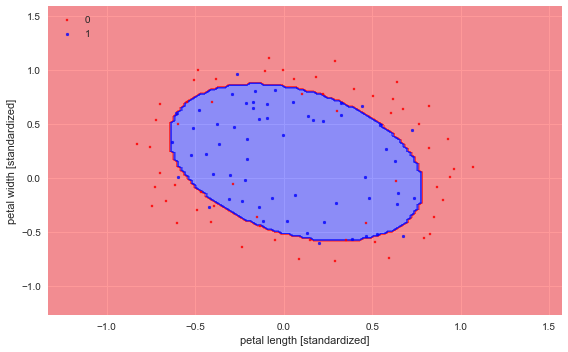

In [59]:
plotDecisionBoundary(X=X_quality,y=y_quality,classifier=gsv)
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()

Conclusion: A logistic regression model was implemented. Model hyper-parameters optimization was optimized using Pipeline and GridSearchCV tools provided by sklearn, which automatically takes care of the data tranformation during the model fitting and prediction. GridSearchCV directly output the optimum hyper-parameters settings. In addition, results showed that Logistic regression can be used not only for linear separable problems, but also some non-linear separable problems by combining polynomial fitting and regularized regression to combat the overfitting.